In [1]:
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import cv2
import torch
from torch import softmax
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, brier_score_loss,log_loss,roc_curve,auc
from torchmetrics.classification import ConfusionMatrix
import argparse
import shutil

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from skimage.transform import resize
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2


# 
# from src.gradcam_model import GradCamModel
from src.dataloader_setter import Dataloader_Setter
# from src.model_ResNet import resnext_scratch
from src.trainer import Trainer
from src.earlystopping import EarlyStopping

# OTHER MODULES
from src.logger import print_logger
from src.seed import seed_everything

/home/jaehan0605/MAIN_ASDfundus/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Figure 1 : AUROC Plot with Zoomed-in View

In [12]:
def func_specificity(y_true, y_pred):
    cm_generator = ConfusionMatrix(task = 'binary', num_classes=2)
    confusionmatrix = cm_generator(preds = torch.tensor(y_pred), target = torch.tensor(y_true))
    specificity = round(int(confusionmatrix[0,0])/(int(confusionmatrix[0,0])+int(confusionmatrix[0,1])), 2)
    return specificity

def func_nll(y_true, y_pred):
    nll = round(log_loss(y_true, y_pred, eps=1e-15, normalize=True),2)
    return nll

def find_youden_index(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]


class ensemble_score_loader : 
    def __init__(self, result_path : Path) : 
        self.result_path = result_path
        self.total_labels = []
        self.total_preds = []
        self.total_scores = []
        self.total_dfs = []
        self.total_tprs = []

    # 95% CI with bootstrap
    def bootstrap_score(self,y_true, y_pred, n_bootstraps=1000, score_type="auc", seed=2023):
        self.score_type = score_type
        yonden_cut = find_youden_index(y_true, y_pred)
        if score_type == "auc" :
            score_func = roc_auc_score
        elif score_type == 'sensitivity':
            score_func = recall_score
            y_pred = y_pred >= 0.5
        elif score_type == 'specificity': 
            score_func = func_specificity
            y_pred = y_pred >= 0.5
        elif score_type == "accuracy" : 
            score_func = accuracy_score
            y_pred = y_pred >= 0.5
        elif score_type == "nll" : 
            score_func = func_nll
            y_pred = y_pred >= 0.5
            nll = []
        elif score_type == "brier" : 
            score_func = brier_score_loss
            y_pred = y_pred >= 0.5 

        np.random.seed(seed)
        bootstrapped_scores = []
        for i in range(n_bootstraps):
            # bootstrap by sampling with replacement on the prediction indices
            indices = np.random.randint(0, len(y_pred), len(y_pred))
            if len(np.unique(y_true[indices])) < 2:
                # We need at least one positive and one negative sample for ROC AUC
                # to be defined: reject the sample
                continue
            score = score_func(y_true[indices], y_pred[indices])
            bootstrapped_scores.append(score)

        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()

        # 95% CI
        avg_score = np.mean(sorted_scores)
        ci_low = sorted_scores[int(0.025 * len(sorted_scores))]
        ci_high = sorted_scores[int(0.975 * len(sorted_scores))]

        return avg_score, ci_low, ci_high
        
    def load_fold_result(self, fold_num : int) : 
        def get_score(y_true, y_pred) : 
            mean_fpr = np.linspace(0, 1, 100)
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            self.total_tprs.append(interp_tpr)
            auc_score = roc_auc_score(y_true, y_pred)
            df_test = pd.DataFrame({'fpr':fpr, 'tpr':tpr})
            df_test['youden_j'] = df_test['tpr'] - df_test['fpr']
            df_test['youden_j'] = df_test['youden_j'].abs()
            return auc_score, df_test

        fold_path = self.result_path.joinpath(f"fold_{fold_num}")
        labels = np.load(fold_path.joinpath("patient_level_labels_ensemble.npy"))
        preds = np.load(fold_path.joinpath("patient_level_preds_ensemble.npy"))
        auc_score, df_test = get_score(labels, preds)

        self.total_labels.extend(labels)
        self.total_preds.extend(preds)
        self.total_scores.append(auc_score)
        self.total_dfs.append(df_test)

    def load_all_result(self) : 
        for fold_num in range(10): 
            self.load_fold_result(fold_num)

        self.mean_tpr = np.mean(self.total_tprs, axis=0)
        self.mean_tpr[-1] = 1.0
        mean_auc = auc(np.linspace(0, 1, 100), self.mean_tpr)
        std_auc = np.std(np.array(self.total_scores).reshape(5, -1), axis=0)
        std_tpr = np.std(self.total_tprs, axis=0)
        self.tprs_upper = np.minimum(self.mean_tpr + std_tpr, 1)
        self.tprs_lower = np.maximum(self.mean_tpr - std_tpr, 0)
        

    def load_total_result(self, score_type = "auc") : 
        self.mean_score = np.mean(self.total_scores)
        avg_score, self.ci_low, self.ci_high = self.bootstrap_score(np.array(self.total_labels), np.array(self.total_preds), score_type = score_type)
        self.avg_score = avg_score
        print(f"{self.score_type if self.score_type != 'auc' else 'AUC'} {avg_score :.3f} ({self.ci_low:.3f}-{self.ci_high:.3f})", end = '\n ')



class singlemodel_score_loader : 
    def __init__(self, result_path : Path) : 
        self.result_path = result_path
        self.total_labels = []
        self.total_preds = []
        self.total_scores = []
        self.total_dfs = []
        self.total_tprs = []

    # 95% CI with bootstrap
    def bootstrap_score(self,y_true, y_pred, n_bootstraps=1000, score_type="auc", seed=2023):
        self.score_type = score_type
        yonden_cut = find_youden_index(y_true, y_pred)
        if score_type == "auc" :
            score_func = roc_auc_score
        elif score_type == 'sensitivity':
            score_func = recall_score
            y_pred = y_pred >= 0.5
        elif score_type == 'specificity': 
            score_func = func_specificity
            y_pred = y_pred >= 0.5
        elif score_type == "accuracy" : 
            score_func = accuracy_score
            y_pred = y_pred >= 0.5
        elif score_type == "nll" : 
            score_func = func_nll
            y_pred = y_pred >= 0.5
            nll = []
        elif score_type == "brier" : 
            score_func = brier_score_loss
            y_pred = y_pred >= 0.5 

        np.random.seed(seed)
        bootstrapped_scores = []
        for i in range(n_bootstraps):
            # bootstrap by sampling with replacement on the prediction indices
            indices = np.random.randint(0, len(y_pred), len(y_pred))
            if len(np.unique(y_true[indices])) < 2:
                # We need at least one positive and one negative sample for ROC AUC
                # to be defined: reject the sample
                continue
            score = score_func(y_true[indices], y_pred[indices])
            bootstrapped_scores.append(score)

        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()

        # 95% CI
        avg_score = np.mean(sorted_scores)
        ci_low = sorted_scores[int(0.025 * len(sorted_scores))]
        ci_high = sorted_scores[int(0.975 * len(sorted_scores))]

        return avg_score, ci_low, ci_high
        
    def load_fold_result(self, fold_num : int) : 
        def get_score(y_true, y_pred) : 
            mean_fpr = np.linspace(0, 1, 100)
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            self.total_tprs.append(interp_tpr)
            auc_score = roc_auc_score(y_true, y_pred)
            df_test = pd.DataFrame({'fpr':fpr, 'tpr':tpr})
            df_test['youden_j'] = df_test['tpr'] - df_test['fpr']
            df_test['youden_j'] = df_test['youden_j'].abs()
            return auc_score, df_test

        fold_path = self.result_path.joinpath(f"fold_{fold_num}")

        for i in range(5):
            labels = np.load(fold_path.joinpath("patient_level_labels_singlemodel.npy"))
            preds = np.load(fold_path.joinpath(f"patient_level_preds_singlemodel_{i}.npy"))
            auc_score, df_test = get_score(labels, preds)

            self.total_labels.extend(labels)
            self.total_preds.extend(preds)
            self.total_scores.append(auc_score)
            self.total_dfs.append(df_test)

    def load_all_result(self) : 
        for fold_num in range(10): 
            self.load_fold_result(fold_num)

        self.mean_tpr = np.mean(self.total_tprs, axis=0)
        self.mean_tpr[-1] = 1.0
        mean_auc = auc(np.linspace(0, 1, 100), self.mean_tpr)
        std_auc = np.std(np.array(self.total_scores).reshape(5, -1), axis=0)
        std_tpr = np.std(self.total_tprs, axis=0)
        self.tprs_upper = np.minimum(self.mean_tpr + std_tpr, 1)
        self.tprs_lower = np.maximum(self.mean_tpr - std_tpr, 0)
        

    def load_total_result(self, score_type = "auc") : 
        self.mean_score = np.mean(self.total_scores)
        avg_score, self.ci_low, self.ci_high = self.bootstrap_score(np.array(self.total_labels), np.array(self.total_preds), score_type = score_type)
        self.avg_score = avg_score
        print(f"{self.score_type if self.score_type != 'auc' else 'AUC'} {avg_score :.3f} ({self.ci_low:.3f}-{self.ci_high:.3f})", end = '\n ')







## Score Load + Boot Strapping

In [13]:
save_path = Path('PAPER_FIGURES').joinpath('Figure!')
save_path.mkdir(parents = True, exist_ok = True)

image_save_path = save_path.joinpath('Figure 1 ASD severity ROC PLOT.pdf')

# result_path = Path('ResNeXt50_deepensemble_ADOS_8')
# result_loader = score_loader(result_path)
# result_loader.load_all_result()

result_path_list = [Path('ResNeXt50_TD_seed_2023_Total'), Path('ResNeXt50_TD_seed_2023_ADOS')]
# result_path_list = [Path('ResNeXt50_TD_seed_2023_0323')]
# result_path_list = [Path('ResNeXt50_deepensemble_SRS_76')]

for result_path in result_path_list:
    result_path = result_path
    result_loader = singlemodel_score_loader(result_path)
    print("<<Single model results>>")
    result_loader.load_all_result()
    print("[", result_path, "]")
    for score_type in ["auc", "sensitivity","specificity","accuracy", "nll", "brier"] :
        result_loader.load_total_result(score_type)

    result_loader = ensemble_score_loader(result_path)
    print("<<Ensemble model results>>")
    result_loader.load_all_result()
    print("[", result_path, "]")
    for score_type in ["auc", "sensitivity","specificity","accuracy", "nll", "brier"] :
        result_loader.load_total_result(score_type)
    

<<Single model results>>
[ ResNeXt50_TD_seed_2023_Total ]
AUC 1.000 (1.000-1.000)
 sensitivity 1.000 (1.000-1.000)
 specificity 1.000 (1.000-1.000)
 accuracy 1.000 (0.999-1.000)
 nll 0.012 (0.000-0.030)
 brier 0.000 (0.000-0.001)
 <<Ensemble model results>>
[ ResNeXt50_TD_seed_2023_Total ]
AUC 1.000 (1.000-1.000)
 sensitivity 1.000 (1.000-1.000)
 specificity 1.000 (1.000-1.000)
 accuracy 1.000 (1.000-1.000)
 nll 0.000 (0.000-0.000)
 brier 0.000 (0.000-0.000)
 <<Single model results>>
[ ResNeXt50_TD_seed_2023_ADOS ]
AUC 1.000 (1.000-1.000)
 sensitivity 1.000 (1.000-1.000)
 specificity 1.000 (1.000-1.000)
 accuracy 1.000 (0.999-1.000)
 nll 0.010 (0.000-0.030)
 brier 0.000 (0.000-0.001)
 <<Ensemble model results>>
[ ResNeXt50_TD_seed_2023_ADOS ]
AUC 1.000 (1.000-1.000)
 sensitivity 1.000 (1.000-1.000)
 specificity 1.000 (1.000-1.000)
 accuracy 1.000 (1.000-1.000)
 nll 0.000 (0.000-0.000)
 brier 0.000 (0.000-0.000)
 

## Draw Plot function - ADOS/SRS

In [14]:
## Set arguments
result_path = Path('ResNeXt50_TD_seed_2023_ADOS')
result_loader = ensemble_score_loader(result_path)
result_loader.load_all_result()
result_loader.load_total_result()

labels = np.array(result_loader.total_labels).reshape(-1)
preds = np.array(result_loader.total_preds).reshape(-1)
avg_cutoff_df = pd.concat(result_loader.total_dfs).reset_index().groupby(['index']).agg('median').reset_index(drop = True)
avg_cutoff = avg_cutoff_df.sort_values(by = 'youden_j', ascending = False).iloc[0, :]['youden_j']
avg_cutoff = avg_cutoff_df.sort_values(by = 'youden_j', ascending = False).iloc[0]
tprs = [result_loader.tprs_lower, result_loader.tprs_upper]


## Set arguments
result_path2 = Path('ResNeXt50_TD_seed_2023_Total')
result_loader2 = ensemble_score_loader(result_path2)
result_loader2.load_all_result()
result_loader2.load_total_result()

labels2 = np.array(result_loader2.total_labels).reshape(-1)
preds2 = np.array(result_loader2.total_preds).reshape(-1)
avg_cutoff_df2 = pd.concat(result_loader2.total_dfs).reset_index().groupby(['index']).agg('median').reset_index(drop = True)
avg_cutoff2 = avg_cutoff_df2.sort_values(by = 'youden_j', ascending = False).iloc[0, :]['youden_j']
avg_cutoff2 = avg_cutoff_df2.sort_values(by = 'youden_j', ascending = False).iloc[0]
tprs2 = [result_loader2.tprs_lower, result_loader2.tprs_upper]

AUC 1.000 (1.000-1.000)
 AUC 1.000 (1.000-1.000)
 

In [15]:
def draw_plot(
                ax, # 그림을 그릴 위치
                labels : np.array, preds : np.array, tprs : list, cutoff_df : pd.DataFrame, line_color : str, # plot을 그리기 위해 필요
                auc_score : np.array, ci : list, cutoff_shape : str, cutoff_label : str, test_name: str# legend를 달기 위해 필요
                ) : 
    # Draw plot with ci a
    
    fpr, tpr, _ = roc_curve(labels, preds, drop_intermediate=False)
    ci_min, ci_max = ci
    tprs_lower, tprs_upper = tprs

    ax.plot(fpr, tpr, label=f'{test_name}: AUROC {auc_score:.3f} (95% CI {ci_min:.3f}-{ci_max:.3f})', lw=2, color = line_color, alpha = 0.7)
    ax.fill_between(np.linspace(0, 1, 100), tprs_lower, tprs_upper, alpha = 0.2)
    # ax.scatter(cutoff_df.fpr, cutoff_df.tpr, marker = cutoff_shape, s=100, label = cutoff_label,  color = 'black')
    ax.plot([0, 1], [0,1], '--', color = 'navy', lw = 2, label = None)

    ax.set_ylabel('Sensitivity')
    ax.set_xlabel('1 - Specificity')

    return fpr, tpr

PAPER_FIGURES/Figure!/Figure 1 ASD severity ROC PLOT.pdf


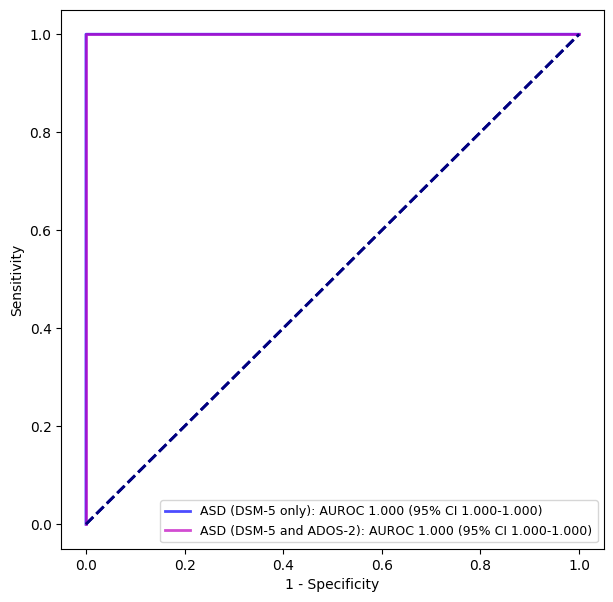

In [16]:
total_dfs = result_loader.total_dfs
total_cutoff_information = []
for fold_num, df in enumerate(total_dfs) : 
    fold_value = df.loc[np.argmax(df['youden_j'])]
    fpr = fold_value['fpr']
    tpr = fold_value['tpr']
    cutoff = fold_value['youden_j']
    total_cutoff_information.append([fold_num, fpr, tpr, cutoff])

cutoff_label = f'Median of Best Cut-off points'

line_color = 'm'
auc_score = result_loader.avg_score
ci = np.array([result_loader.ci_low, result_loader.ci_high])
cutoff_shape = '^'
cutoff_label = f'Median of Best Cut-off points'
test_name = 'ASD (DSM-5 only)'

total_dfs2 = result_loader2.total_dfs
total_cutoff_information2 = []
for fold_num, df in enumerate(total_dfs2) : 
    fold_value = df.loc[np.argmax(df['youden_j'])]
    fpr = fold_value['fpr']
    tpr = fold_value['tpr']
    cutoff = fold_value['youden_j']
    total_cutoff_information2.append([fold_num, fpr, tpr, cutoff])

cutoff_label2 = f'Median of Best Cut-off points'

line_color2 = 'b'
auc_score2 = result_loader2.avg_score
ci2 = np.array([result_loader2.ci_low, result_loader2.ci_high])
cutoff_shape = '^'
cutoff_label2 = f'Median of Best Cut-off points'
test_name2 = "ASD (DSM-5 and ADOS-2)"

## DRAW Plot with Calculated ci
fig, ax = plt.subplots(figsize = (7, 7))

draw_plot(ax, 
            labels2, preds2, tprs2, avg_cutoff2, line_color2, 
            auc_score2, ci2, cutoff_shape, cutoff_label, test_name=test_name)

draw_plot(ax, 
            labels, preds, tprs, avg_cutoff, line_color, 
            auc_score, ci, cutoff_shape, cutoff_label, test_name=test_name2)

ax.legend(bbox_to_anchor = (1, 0), fontsize = 9, loc = 'lower right')
plt.savefig(image_save_path, format = 'pdf', dpi = 300, bbox_inches = 'tight')
print(image_save_path)

## Draw Plot function - ASD vs TD

In [102]:
## Set arguments
result_path = Path('ResNeXt50_TD_seed_2023_0323')
result_loader = ensemble_score_loader(result_path)
result_loader.load_all_result()
result_loader.load_total_result()

labels = np.array(result_loader.total_labels).reshape(-1)
preds = np.array(result_loader.total_preds).reshape(-1)
avg_cutoff_df = pd.concat(result_loader.total_dfs).reset_index().groupby(['index']).agg('median').reset_index(drop = True)
avg_cutoff = avg_cutoff_df.sort_values(by = 'youden_j', ascending = False).iloc[0, :]['youden_j']
avg_cutoff = avg_cutoff_df.sort_values(by = 'youden_j', ascending = False).iloc[0]
tprs = [result_loader.tprs_lower, result_loader.tprs_upper]

AUC 1.000 (1.000-1.000)
 

In [103]:
def draw_plot(
                ax, # 그림을 그릴 위치
                labels : np.array, preds : np.array, tprs : list, cutoff_df : pd.DataFrame, line_color : str, # plot을 그리기 위해 필요
                auc_score : np.array, ci : list, cutoff_shape : str, cutoff_label : str, test_name: str# legend를 달기 위해 필요
                ) : 
    # Draw plot with ci a
    
    fpr, tpr, _ = roc_curve(labels, preds, drop_intermediate=False)
    ci_min, ci_max = ci
    tprs_lower, tprs_upper = tprs

    ax.plot(fpr, tpr, label=f'{test_name}: AUROC {auc_score:.3f} (95% CI {ci_min:.3f}-{ci_max:.3f})', lw=2, color = line_color, alpha = 0.7)
    ax.fill_between(np.linspace(0, 1, 100), tprs_lower, tprs_upper, alpha = 0.2)
    # ax.scatter(cutoff_df.fpr, cutoff_df.tpr, marker = cutoff_shape, s=100, label = cutoff_label,  color = 'black')
    ax.plot([0, 1], [0,1], '--', color = 'navy', lw = 2, label = None)

    ax.set_ylabel('Sensitivity')
    ax.set_xlabel('1 - Specificity')

    return fpr, tpr

In [ ]:
total_dfs = result_loader.total_dfs
total_cutoff_information = []
for fold_num, df in enumerate(total_dfs) : 
    fold_value = df.loc[np.argmax(df['youden_j'])]
    fpr = fold_value['fpr']
    tpr = fold_value['tpr']
    cutoff = fold_value['youden_j']
    total_cutoff_information.append([fold_num, fpr, tpr, cutoff])

cutoff_label = f'Median of Best Cut-off points'

line_color = 'b'
auc_score = result_loader.avg_score
ci = np.array([result_loader.ci_low, result_loader.ci_high])
cutoff_shape = '^'
cutoff_label = f'Median of Best Cut-off points'
test_name = 'ASD vs TD'

## DRAW Plot with Calculated ci
fig, ax = plt.subplots(figsize = (6, 6))

draw_plot(ax, 
            labels2, preds2, tprs2, avg_cutoff2, line_color2, 
            auc_score2, ci2, cutoff_shape, cutoff_label, test_name=test_name)

draw_plot(ax, 
            labels, preds, tprs, avg_cutoff, line_color, 
            auc_score, ci, cutoff_shape, cutoff_label, test_name=test_name2)

ax.legend(bbox_to_anchor = (1, 0), fontsize = 9, loc = 'lower right')
plt.savefig(image_save_path, format = 'pdf', dpi = 300, bbox_inches = 'tight')
print(image_save_path)

## Performance plot

In [97]:
total_scores = []
for score_type in ["auc", "sensitivity", "specificity", "accuracy"] :
    result_loader.load_total_result(score_type)
    avg_score = result_loader.avg_score
    ci_low = result_loader.ci_low
    ci_high = result_loader.ci_high
    total_scores.append([score_type, avg_score, ci_low, ci_high])

score_df = pd.DataFrame(total_scores, columns = ['score_type', 'avg_score', 'ci_low', 'ci_high'])
score_df

AUC 0.438 (0.384-0.497)
 sensitivity 0.523 (0.458-0.594)
 specificity 0.443 (0.380-0.510)
 accuracy 0.484 (0.440-0.528)
 

,score_type,avg_score,ci_low,ci_high
0,auc,0.437541,0.384485,0.496668
1,sensitivity,0.523029,0.458333,0.593607
2,specificity,0.442920,0.380000,0.510000
3,accuracy,0.483798,0.439535,0.527907


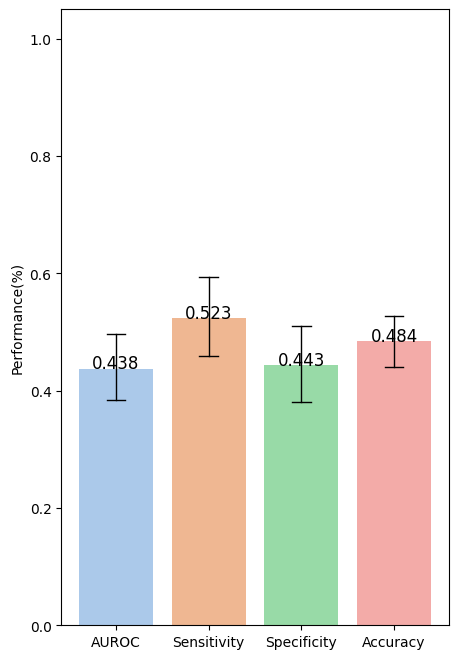

In [98]:
plt.figure(figsize = (5,8))

ax = sns.barplot(data = score_df, x = 'score_type', y = 'avg_score', palette = 'pastel')

for i, row in score_df.iterrows() :
    ci_low = row['ci_low']
    ci_high = row['ci_high']
    avg_score = row['avg_score']

    plt.plot([i, i], [ci_low, ci_high], color = 'black', lw = 1)
    plt.plot([i - 0.1, i + 0.1], [ci_low, ci_low], color = 'black', lw = 1)
    plt.plot([i - 0.1, i + 0.1], [ci_high, ci_high], color = 'black', lw = 1)
    plt.text(i, avg_score, f'{avg_score:.3f}', ha = 'center', fontsize = 12)


h, l = ax.get_legend_handles_labels()
plt.xticks(range(4), ['AUROC', 'Sensitivity', 'Specificity', 'Accuracy'])
plt.ylabel('Performance(%)')
plt.ylim(0, 1.05)
plt.xlabel('')

image_save_path = image_save_path.with_name('Figure 2 Performance of Healthy vs ASD.pdf')
plt.savefig(image_save_path, format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show()